# Get cluster scatter

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import astropy.stats as aps
from tqdm.notebook import tqdm
from tqdm import trange

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load cluster data and apply cuts

In [3]:
clusters = pd.read_csv("../data/dbf12.csv")

# Do all sorts of cuts on the clusters to remove scatter.
# Remove points that are redder than 1.5 AND have periods shorter than 11 days to get rid of scatter.
ms = (clusters["(BP-RP)0"].values > 1.5) & (clusters.prot.values < 11)

# Remove any rotation periods shorter than 1 day, stars redder than 2.2.
not_fast = (clusters.prot.values[~ms] > 1) & (clusters["(BP-RP)0"].values[~ms] < 2.7) & (clusters["(BP-RP)0"].values[~ms] < 2.2)

# Remove the Pleiades non-converged stars and three outliers.
# no_pleiades = clusters.age_gyr.values[~ms][not_fast] < 0.2
no_pleiades = (clusters.age_gyr.values[~ms][not_fast] <= 0.2) & (clusters["(BP-RP)0"].values[~ms][not_fast] > 1.4)
outliers1 = (clusters.age_gyr.values[~ms][not_fast][~no_pleiades] <= 0.2) \
    & (clusters["(BP-RP)0"].values[~ms][not_fast][~no_pleiades] > .7) \
    & (clusters.prot.values[~ms][not_fast][~no_pleiades] < 2)
outliers2 = (clusters.age_gyr.values[~ms][not_fast][~no_pleiades][~outliers1] <= 0.2) \
    & (clusters["(BP-RP)0"].values[~ms][not_fast][~no_pleiades][~outliers1] < .7) \
    & (clusters.prot.values[~ms][not_fast][~no_pleiades][~outliers1] > 5)

# Apply cuts
cluster_x = clusters["(BP-RP)0"].values[~ms][not_fast][~no_pleiades][~outliers1][~outliers2]
cluster_prot = clusters.prot.values[~ms][not_fast][~no_pleiades][~outliers1][~outliers2]
cluster_age = clusters.age_gyr.values[~ms][not_fast][~no_pleiades][~outliers1][~outliers2]
no_nan = np.isfinite(cluster_x) & np.isfinite(cluster_prot) & np.isfinite(cluster_age) & (cluster_age > 0) & (cluster_prot > 0)
cluster_x, cluster_prot, cluster_age = cluster_x[no_nan], cluster_prot[no_nan], cluster_age[no_nan]

Functions for calculating scatter (tested and developed in GP_hackszors).

In [6]:
def subtract_lil_line(x, y, order):
    pv = np.polyfit(x, y, order)
    return y - np.polyval(pv, x), pv

In [7]:
def running_scatter(xval, yval, width=.1):
    assert len(xval) == len(yval)
    
    # For each data point, select stars within an x value range of width.
    stds = np.empty(len(yval))
    for i in trange(len(xval)):
        m = abs(xval[i] - xval) < width
        y_corrected, p = subtract_lil_line(xval[m], yval[m], 3)
        stds[i] = aps.median_absolute_deviation(y_corrected) * 1.5
    return stds

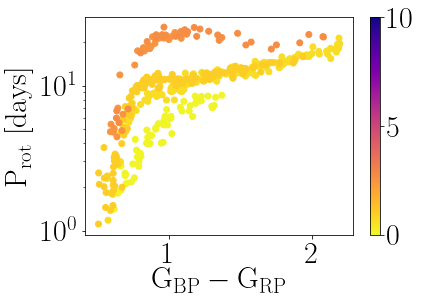

In [9]:
plt.scatter(cluster_x, cluster_prot, c=cluster_age, vmin=0, vmax=10, cmap="plasma_r")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.yscale("log")
plt.colorbar();

100%|██████████| 35/35 [00:00<00:00, 2077.03it/s]


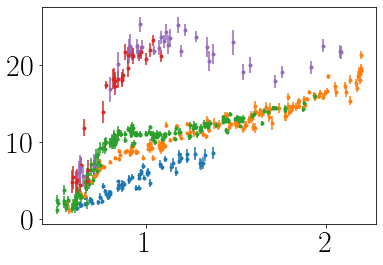

In [14]:
yerrors = []
for a in np.unique(cluster_age):
    age_mask = cluster_age == a
    
    x_, y_ = cluster_x[age_mask], cluster_prot[age_mask]
    stds = np.empty(len(y_))
    for i in trange(len(x_)):
        width = .1
        m = abs(x_[i] - x_) < width
        while sum(m) < 10:
            width += .1
            m = abs(x_[i] - x_) < width
        y_corrected, p = subtract_lil_line(x_[m], y_[m], 2)
        stds[i] = aps.median_absolute_deviation(y_corrected) * 1.5
        
    plt.errorbar(cluster_x[age_mask], cluster_prot[age_mask], yerr=stds, fmt=".")
    yerrors.append(stds)
    
yerrors = np.array([i for j in yerrors for i in j])

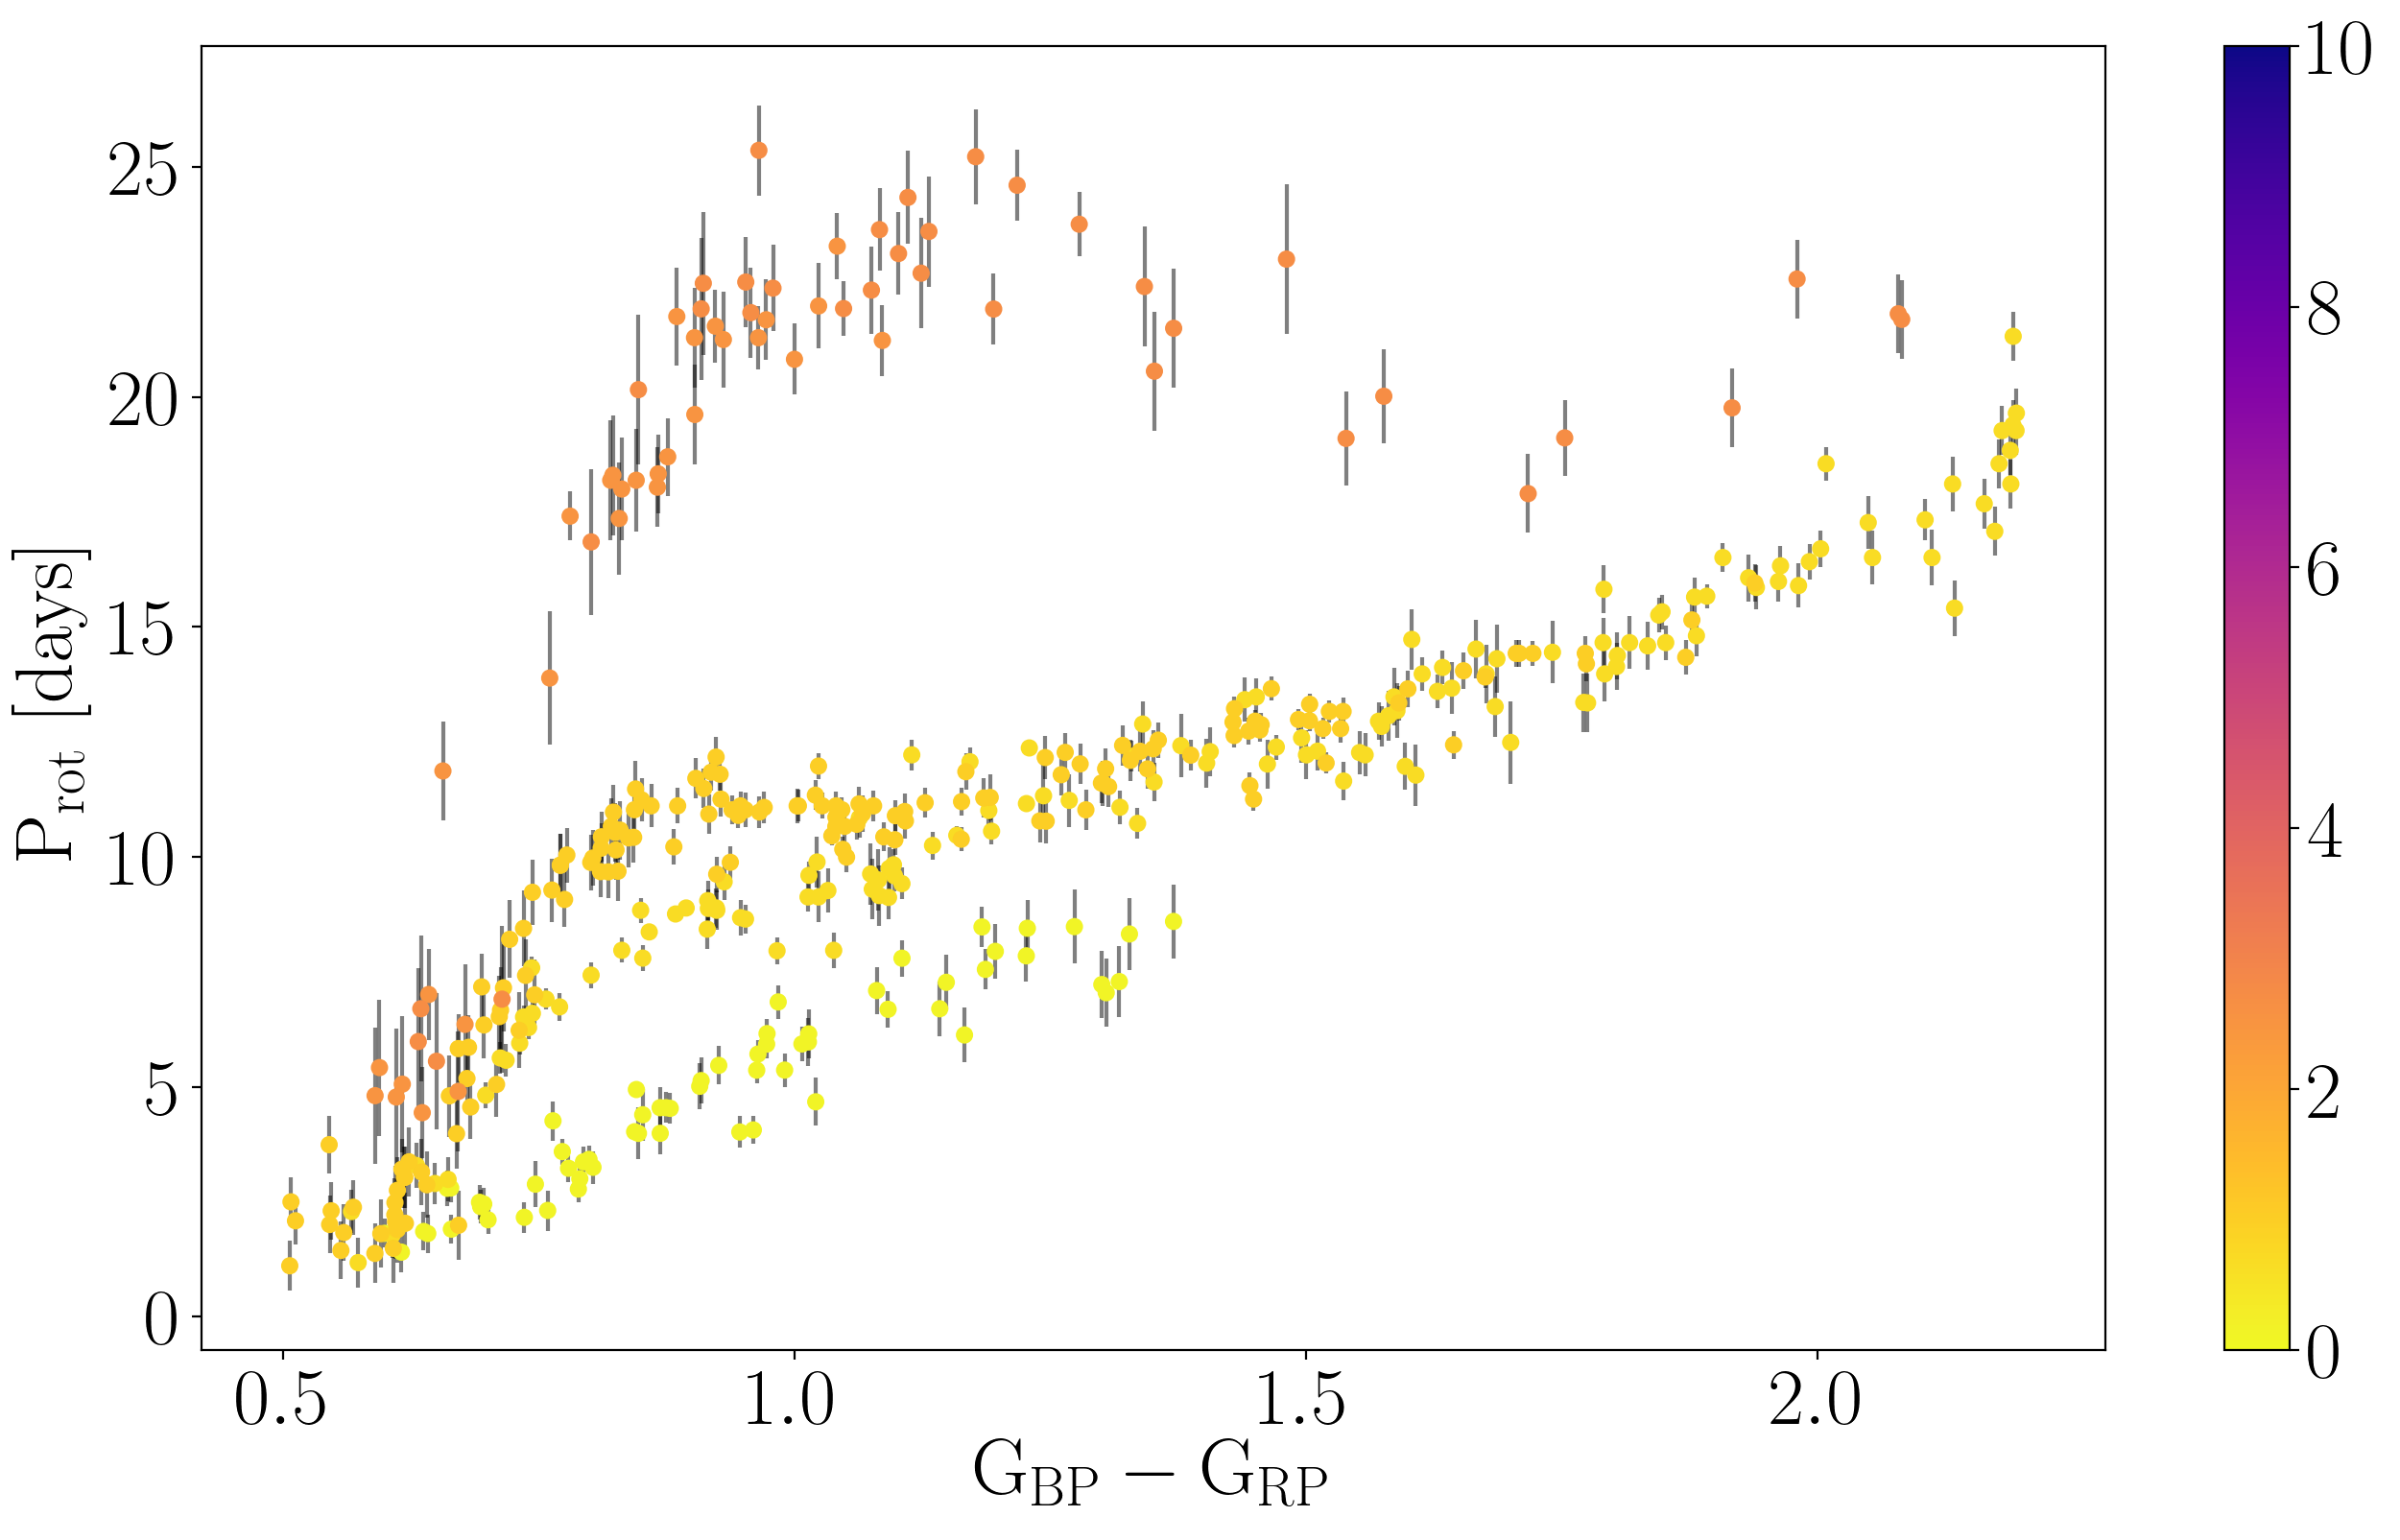

In [20]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(cluster_x, cluster_prot, yerr=yerrors, fmt="k.", alpha=.5, zorder=0)
plt.scatter(cluster_x, cluster_prot, c=cluster_age, vmin=0, vmax=10, s=30, cmap="plasma_r")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
# plt.yscale("log")
plt.colorbar();

In [21]:
df = pd.DataFrame(dict({"bprp": cluster_x,
                        "prot": cluster_prot,
                        "age": cluster_age,
                        "prot_err": yerrors}))
df.to_csv("../data/clusters_with_uncertainties.csv")

# Now estimate the scatter in the kinematic ages somehow...

Perhaps subtract one of the latests model fits from the data and look at the residuals?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import astropy.stats as aps
from tqdm.notebook import tqdm
from tqdm import trange

from cv_routines import *

In [2]:
young_limit = .7  # .1 is worse.
old_limit = 20.
hot_limit = 1.
dp, dc = .05, .05
cluster_old_err = .05  # The relative prot uncertainty on Ruprecht 147 and NGC6819
abs_kinerrs = 3  # The absolute prot uncertainty """"""
sun_err = .01  # The absolute prot uncertainty on the Sun's rotation period.

x, age, prot, prot_err, ID, akin, cluster_x, cluster_prot, cluster_age = assemble_data(
    young_limit, old_limit, hot_limit, dp, dc, cluster_old_err, abs_kinerrs, sun_err)

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Fit a model to the data just to use for estimating the scatter.

In [3]:
filename = "../data/scatter_model.pkl"

age_grid = np.log(np.array([.12, .67,1, 1.6, 2.7, 4, 4.56, 8, 10, 14]))
# age_grid = np.linspace(np.log(.12), np.log(14), 10)
# age_grid = np.log10(np.linspace(1, 14, 10))

map_soln = av.fit_gp(x, age, prot, prot_err, filename, age_grid=age_grid)

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1133.5625576977834 -> -1129.508002866347
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1129.508002866347 -> -1128.8469911522047
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1128.8469911522047 -> -1126.851023078782
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1126.851023078782 -> -1125.0029158704285
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1125.0029158704285 -> 133.56698594238242
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]


message: Optimization terminated successfully.
logp: 133.56698594238242 -> 147.0130676805291


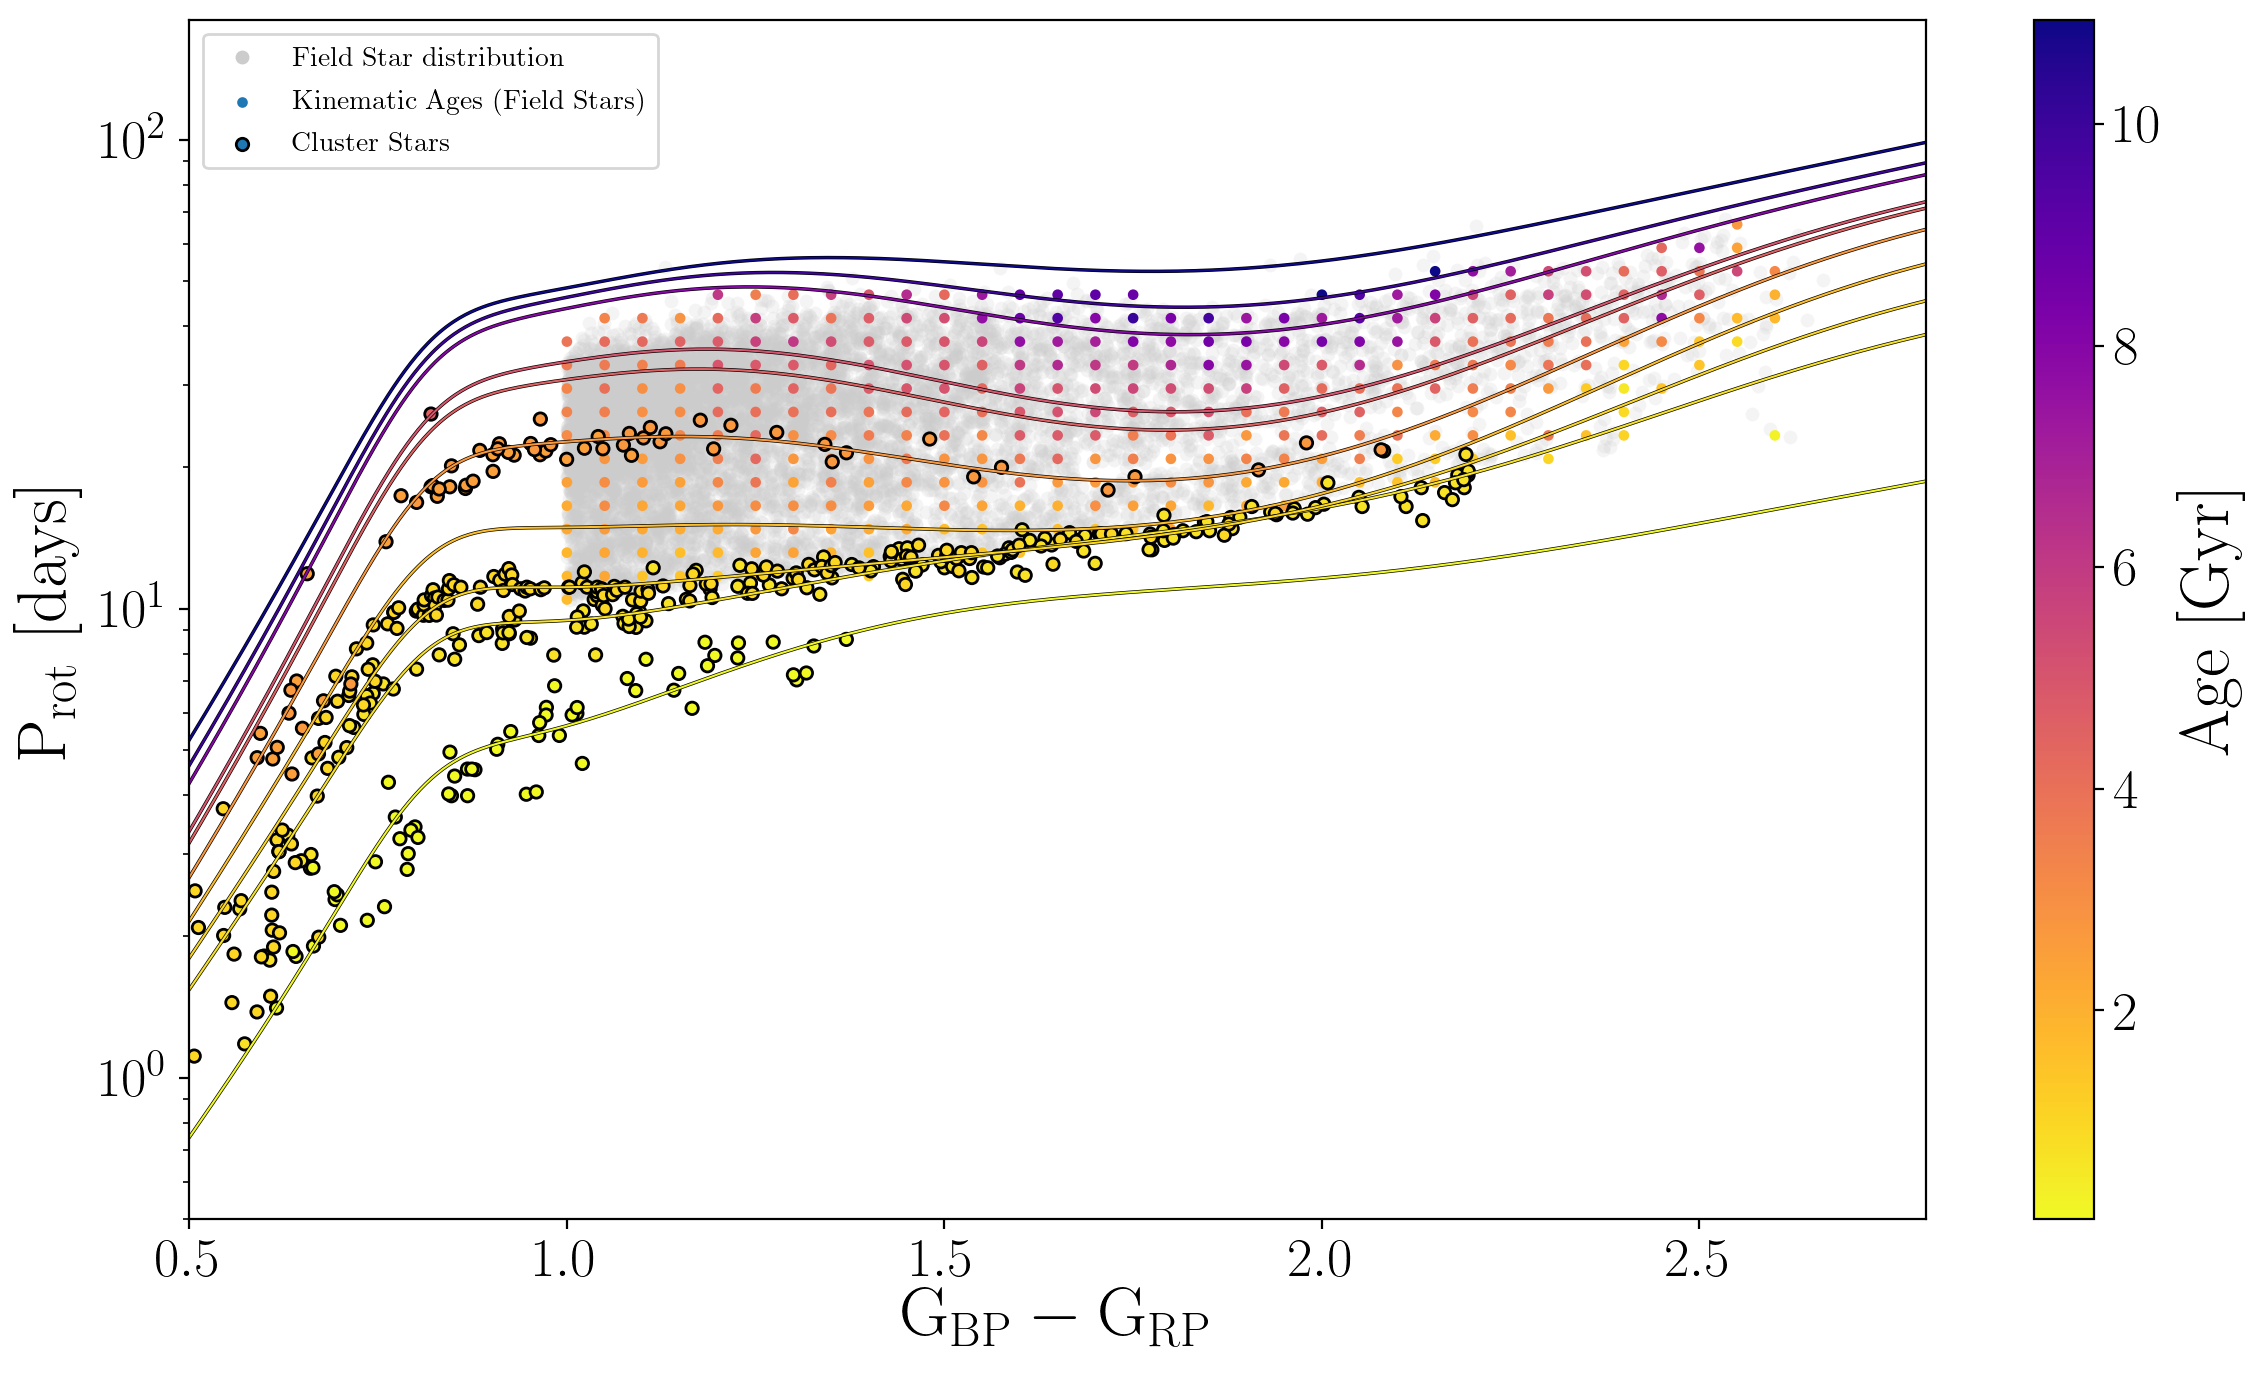

In [4]:
make_plot(akin, x, age, prot, prot_err, cluster_x, cluster_prot, cluster_age, filename)

In [5]:
map_soln["log_s2"], map_soln["log_ell1"]

(array(-6.32080476), array([-0.11319898,  0.06062793]))

In [9]:
# map_soln["log_s2"], map_soln["log_ell1"]
# (array(-3.95039298), array([-1.50457495, -0.52196534]))

(array(-3.95039298), array([-1.50457495, -0.52196534]))

In [5]:
x2_min = .12

def log_period_model(x2, log_period_break_m, log_period_break_b):
    """
    2nd-order polynomial describing relationship between period and
    age. period = m*logage + b
    """
    return log_period_break_m * (x2 - x2_min) + log_period_break_b

# Mean model
def gyro_mean_model(x1, x2, log_period_break_m, log_period_break_b,
                    teff_break, slope_low, slope_high, smooth):
    """
    Predict the period at given values of color and age.
    Use a smoothed broken power law for the period - color relation.
    Use get_log_period_break for the period - age relation.
    """
    delta = x1 - teff_break
    brk = log_period_model(x2, log_period_break_m, log_period_break_b)  # Get the period at this age
    slope = slope_low / (1 + np.exp(smooth * delta)) \
        + slope_high / (1 + np.exp(-smooth * delta))
    return slope * delta + brk

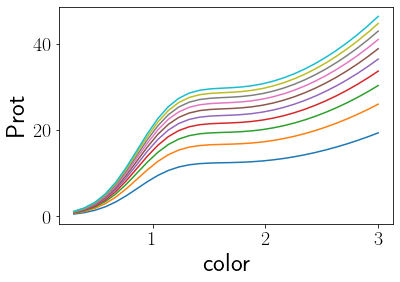

In [6]:
age_plot = np.log(np.linspace(1, 14, 10))
x_plot = np.linspace(.3, 3., 30)

lp = []
for a in age_plot:
    log_p = gyro_mean_model(x_plot, a, map_soln["log_period_break_m"], map_soln["log_period_break_b"],
                            map_soln["teff_break"], map_soln["slope_low"], map_soln["slope_high"],
                            map_soln["log_smooth"])
    plt.plot(x_plot, np.exp(log_p))
plt.xlabel("color")
plt.ylabel("Prot");